In [2]:
import pandas as pd
import numpy as np

#modeling
import lightgbm as lgb

#Evaluation of the model
from sklearn.model_selection import KFold

MAX_EVALS = 500
N_FOLDS = 10

In [3]:
data = pd.read_csv('D:\code\pyproject\MLlearing\HyperparameterOptimization\data\caravan-insurance-challenge.csv')

train = data[data['ORIGIN']=='train']
test = data[data['ORIGIN']=='test']

train_labels = np.array(train['CARAVAN'].astype(np.int32)).reshape((-1,))
test_labels = np.array(test['CARAVAN'].astype(np.int32)).reshape((-1,))

# Drop the unneeded columns
train = train.drop(columns= ['ORIGIN', 'CARAVAN'])
test = test.drop(columns= ['ORIGIN', 'CARAVAN'])


features = np.array(train)
test_features = np.array(test)

labels = train_labels[:]

print('Train shape', train.shape)
print('Test shape', test.shape)
train.head()

Train shape (5822, 85)
Test shape (4000, 85)


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


Text(0.5, 1.0, 'counts of labels')

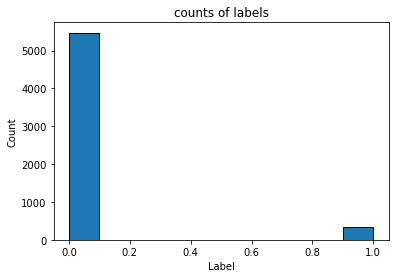

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.hist(labels, edgecolor='k')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('counts of labels')

In [11]:
model = lgb.LGBMClassifier()
model

LGBMClassifier()

In [12]:
from sklearn.metrics import roc_auc_score
from timeit import default_timer as timer

start = timer()
model.fit(features,labels)
train_time = timer()-start
# predict_proba不同于predict，它返回的预测值为，获得所有结果的概率。
predictions = model.predict_proba(test_features)[:, 1]
auc = roc_auc_score(test_labels, predictions)

print('The baseline score on the test set is {:.4f}.'.format(auc))
print('The baseline training time is {:.4f} seconds'.format(train_time))

The baseline score on the test set is 0.7092.
The baseline training time is 0.4660 seconds


## random search

In [13]:
lgb.LGBMClassifier()

LGBMClassifier()

In [15]:
# Hyperparameter grid
param_grid = {
    'class_weight':[None, 'balanced'],
    'boosting_type':['gbdt','goss','dart'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base=np.exp(1), num=1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}

# Subsampling (only applicable with 'goss')
subsample_dist = list(np.linspace(0.5, 1, 100))

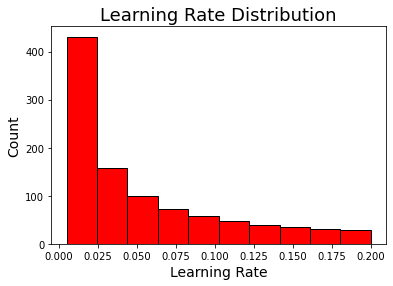

In [16]:
plt.hist(param_grid['learning_rate'], color = 'r', edgecolor = 'k')
plt.xlabel('Learning Rate', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Learning Rate Distribution', size = 18);

Text(0.5, 1.0, 'Number of leaves Distribution')

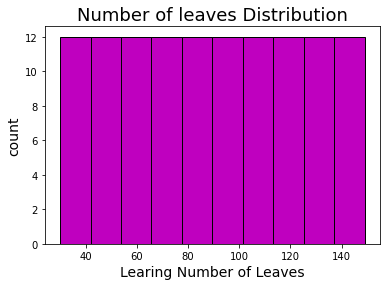

In [17]:
plt.hist(param_grid['num_leaves'], color='m', edgecolor='k')
plt.xlabel('Learing Number of Leaves', size=14)
plt.ylabel('count', size = 14)
plt.title('Number of leaves Distribution', size = 18)

## Sampling from Hyperparameter Domin

In [19]:
#Randomly sample parameters for gbm
import random
#random.sample(value,1) 从value 抽一个
params = {key: random.sample(value,1)[0] for key, value in param_grid.items()}

params

{'class_weight': None,
 'boosting_type': 'gbdt',
 'num_leaves': 69,
 'learning_rate': 0.05848035476425735,
 'subsample_for_bin': 20000,
 'min_child_samples': 280,
 'reg_alpha': 0.836734693877551,
 'reg_lambda': 0.5714285714285714,
 'colsample_bytree': 0.8666666666666667}

In [20]:
#To add a subsample ratio if the boosting_type is not goss, we can use an if statement.
# set the subsample to 1.0 if boosting type is goss
params['subsample'] = random.sample(subsample_dist,1)[0] if params['boosting_type'] !='goss' else 1.0
params

{'class_weight': None,
 'boosting_type': 'gbdt',
 'num_leaves': 69,
 'learning_rate': 0.05848035476425735,
 'subsample_for_bin': 20000,
 'min_child_samples': 280,
 'reg_alpha': 0.836734693877551,
 'reg_lambda': 0.5714285714285714,
 'colsample_bytree': 0.8666666666666667,
 'subsample': 0.6464646464646464}

## Cross Validation with Early Stopping in LightGBM

In [21]:
train_set = lgb.Dataset(features, label=labels)

In [23]:
r = lgb.cv(params, train_set, num_boost_round=10000, nfold=10, metrics='auc',
           early_stopping_rounds=100, verbose_eval = False, seed=50)

#Highest score
r_best = np.max(r['auc-mean'])

#Standard deviation of best score
r_best_std = r['auc-stdv'][np.argmax(r['auc-mean'])]

print('The maximium ROC AUC on the validation set was {:.5f} with std of {:.5f}.'.format(r_best, r_best_std))
print('The ideal number of iterations was {}.'.format(np.argmax(r['auc-mean']) + 1))

The maximium ROC AUC on the validation set was 0.76218 with std of 0.03678.
The ideal number of iterations was 43.


## Results Dataframe

In [ ]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params', 'iteration', 'estimators', 'time'],
                       index = list(range(MAX_EVALS)))


In [ ]:
def random_objective(params, iteration, n_folds= N_FOLDS):
    start = timer()

    cv_result